In [0]:
import os
import re
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from nltk import tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import LancasterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.corpus import stopwords 
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from google.colab import drive
drive.mount('/content/drive')



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Import the top 5 sentences in related articles that have the highest similarity with claims
import json
with open("/content/drive/My Drive/MIE1624 team project/Project/related_sentences.json", 'r') as f:
    related_sentences = json.load(f)
with open("/content/drive/My Drive/MIE1624 team project/Project/train.json", 'r') as f:
    claims = json.load(f)

In [0]:
label = []
claim = []
index = []

for c in claims:
  label.append(c['label'])
for c in claims: 
  claim.append(c['claim'])
for c in related_sentences: 
  index.append(c)

In [0]:
# Perform simple cleaning to the related sentences
def cleaning(article):
    
    tokenizer = RegexpTokenizer(r'\w+')
    lrStem = LancasterStemmer()
    wnLemm = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    article.replace('-',' ')
    
    article_words = tokenizer.tokenize(article)
    #article_words = [lrStem.stem(w) for w in article_words] # add stemmer
    article_words = [wnLemm.lemmatize(w,'v') for w in article_words] # add lemmatizer           
    article_words = [w.lower() for w in article_words if not w in stop_words] # remove stop word

    return article_words

For each sentence and the claim, word embedding is implemented to find the keywords and their corresponding vectors with a pre-determined vector dimension. 

Then an average of the vectors is taken across the sentences, to be considered as an input feature for prediction purpose.

In [0]:
final_features = []
dim = 20

# First loop across indices which represents different claims
for ind in index: 
  print("claim: ", ind)
  splitted_sentences = []
  vocab = []
  sentences = []
  cleaned = []
  features = []
  final = []

  # Apply the cleaning function to sentences and corresponding claim
  for sen in related_sentences[str(ind)]:
    sentences = cleaning(sen)
    splitted_sentences.append(sentences)
  
  cleaned = cleaning(claim[int(ind)])
  splitted_sentences.append(cleaned)
  
  # Create word embedding model for the splitted sentence
  model = Word2Vec(splitted_sentences, size=dim, window=5, min_count=1)

  # Obtain vocabulary list
  vocab = list(model.wv.vocab)
  length = len(vocab)
  avg_vectors = []

  # Record the vector representing each word in sentence and calculate the average across such sentence
  for i in range(0, len(splitted_sentences)):
    vec_sum = [0] * dim
    vec_count = 0
    for word in splitted_sentences[i]: 
      if word in vocab: 
        vector = list(model[str(word)])
        vec_sum = [sum(i) for i in zip(vec_sum, vector)]
        vec_count += 1
      else: 
        continue
    if vec_count > 0: 
      avg_vector = [x / vec_count for x in vec_sum]
      features.append(avg_vector)
    else: 
      features.append(vec_sum)

  if len(splitted_sentences) < 6:
    diff = 6 - len(splitted_sentences)
    for m in range(0, diff): 
      fillin = [0] * dim
      features.append(fillin)
  # Combine all vectors under the same claim together
  final = np.asarray(features).flatten()
  # Attach the resulting overall vector in the final list as features
  final_features.append(final.tolist())

In [0]:
len(final_features)

15555

In [0]:
df = pd.DataFrame(final_features)
df['label'] = label

# Row represents each claim and columns represents the combined vector dimension
df.shape

(15555, 121)

In [0]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,label
0,-0.004771,0.005232,-0.006646,0.003041,0.002648,-0.003402,0.000109,0.001810,0.007187,0.000306,-0.003734,0.002724,-0.005243,-0.000529,0.008428,0.005393,0.001355,-0.001267,-0.009619,-0.003787,0.006800,0.021181,-0.018234,0.006989,0.019119,-0.005957,-0.024564,0.016441,0.003435,0.000720,0.017349,0.008907,0.015155,0.023885,0.005263,-0.002241,-0.000615,0.001610,-0.017355,0.001709,...,0.002613,-0.002895,0.002766,-0.002218,-0.004661,0.001715,-0.003099,0.008847,0.003736,-0.000378,-0.002138,0.001541,-0.006024,-0.003995,-0.000228,0.002140,0.000115,-0.009083,-0.003714,-0.004466,-0.004300,-0.002851,0.001295,-0.000203,-0.005784,0.005517,0.010029,0.005132,0.001441,-0.003065,0.006382,-0.003244,0.002462,0.004972,0.005967,0.001536,0.000525,-0.004171,-0.001723,0
1,-0.000832,-0.003326,0.007091,-0.002005,-0.000881,0.004816,0.005753,0.006894,-0.011531,0.001232,0.001747,-0.001217,0.000861,0.004024,0.001394,-0.003019,-0.005326,-0.001516,-0.006703,-0.002344,-0.003579,0.004112,0.001943,0.000111,-0.000589,0.002792,-0.001130,0.000819,-0.007814,-0.002831,0.002374,0.001777,0.003607,-0.001014,0.003242,0.000759,-0.002945,-0.001363,-0.003242,0.001023,...,0.005517,0.003280,0.003635,0.001533,0.001840,-0.002998,-0.002470,-0.000543,-0.001683,-0.000208,-0.001818,0.001873,-0.000291,-0.002583,0.000247,-0.006553,0.000978,0.001397,0.003310,-0.003672,0.003472,0.003021,0.004587,0.002946,0.004421,0.000891,-0.002394,-0.005005,0.001149,0.004802,0.005917,0.004115,0.001710,-0.001861,-0.001636,-0.001091,0.003624,-0.002942,0.000966,2
2,-0.000136,0.000352,-0.002417,-0.001282,0.004596,0.005003,0.004379,0.000807,0.000520,-0.000784,-0.004345,-0.002994,0.000600,0.000286,0.001871,-0.003150,-0.005162,0.001494,0.000283,0.000210,0.001711,-0.000759,-0.002768,-0.003119,0.005318,0.003054,0.003187,0.003281,0.002025,-0.001429,-0.005230,-0.001327,0.000885,-0.000494,0.003797,-0.003895,-0.000398,0.000865,0.002324,-0.002358,...,0.002876,-0.000060,-0.001363,-0.003385,0.000911,-0.002335,-0.000612,0.001845,-0.001996,-0.004168,0.002433,0.001170,0.001094,-0.000804,0.002680,0.000140,0.002145,-0.001764,-0.001781,0.004568,-0.004200,0.001513,0.000374,0.010697,0.004116,0.005491,-0.002466,-0.005788,0.000197,-0.003337,-0.000270,-0.000718,-0.001194,-0.003104,-0.001984,-0.004785,0.005673,0.001333,0.004777,1
3,-0.001586,0.002469,0.004798,0.003074,-0.005582,0.001946,0.004840,0.001260,-0.003901,-0.001295,0.000855,-0.004621,-0.003453,-0.002533,-0.004012,0.000552,0.001870,0.000990,-0.003155,-0.001827,-0.000887,-0.002338,0.005581,-0.004430,-0.004579,-0.006769,-0.002925,0.006991,-0.005542,-0.001373,-0.002288,-0.007915,-0.004660,0.000504,0.000247,-0.005434,-0.000550,0.002900,-0.000832,-0.003019,...,-0.007023,-0.002595,-0.003749,0.003219,-0.003845,-0.004245,-0.003027,0.000270,-0.002535,-0.006446,-0.005276,0.001440,0.002476,-0.004419,-0.002793,-0.000412,-0.002709,0.002733,0.002030,-0.001185,0.003959,0.001261,0.005511,0.000493,-0.002966,0.003081,-0.003748,-0.000618,-0.002990,-0.002309,-0.008719,-0.002409,-0.001367,0.002116,0.006294,-0.000113,0.001581,-0.004157,-0.003318,2
4,0.002273,0.002235,0.000052,0.008927,0.000242,-0.001800,0.002939,0.001092,0.008790,0.004340,-0.000299,0.001265,-0.003167,0.006048,0.009077,-0.002493,-0.000818,0.003715,0.004557,-0.001644,0.004923,-0.003746,0.004933,-0.002749,0.003755,0.003185,0.002702,0.004732,0.000858,-0.000467,-0.007230,-0.004161,-0.005659,-0.004972,0.002216,0.000748,-0.000237,-0.004527,0.005171,0.003568,...,-0.008379,-0.001779,-0.000579,0.001729,0.004291,-0.000594,-0.005332,0.002769,0.002312,0.000540,-0.000034,0.000013,-0.007184,0.005529,-0.002404,0.006377,-0.002076,-0.004404,0.006691,0.000790,0.003355,0.001770,0.003346,-0.002969,0.003092,0.004826,0.001848,0.008973,0.002550,0.000396,-0.002726,-0.001650,0.006350,0.006974,-0.0035

In [0]:
x = df.drop(columns = ['label'])
y = df['label']

In [0]:
# Split the input and true value into training and testing sets
x_train, x_test, y_train, y_test = train_test_split (x, y, test_size=0.3, random_state=42)

In [0]:
# Create a logistic regression model for the dataset
lr_model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
lr_model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred = lr_model.predict(np.array(x_test))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      1.00      0.65      2228
           1       0.47      0.00      0.01      1934
           2       0.00      0.00      0.00       505

    accuracy                           0.48      4667
   macro avg       0.32      0.33      0.22      4667
weighted avg       0.42      0.48      0.31      4667



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
# Perform Grid Search tuning for the logistic regression model
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf = GridSearchCV(LogisticRegression(), param_grid, cv=10)
tuned_clf = clf.fit(x_train, y_train)

In [0]:
prediction = tuned_clf.predict(x_test)

resultDF = pd.DataFrame()

resultDF['Claim'] = pd.Series()
resultDF['Label'] = y_test
resultDF['Prediction'] = prediction

resultDF.shape

(4667, 3)

In [0]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.49      0.88      0.63      2228
           1       0.47      0.16      0.23      1934
           2       0.00      0.00      0.00       505

    accuracy                           0.49      4667
   macro avg       0.32      0.35      0.29      4667
weighted avg       0.43      0.49      0.40      4667



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
# Save the the trained model to disk
from joblib import dump, load
dump(tuned_clf, '/content/drive/My Drive/MIE1624 team project/Project/Project Submission/Word Embedding Approach/lrmodel.joblib')

['/content/drive/My Drive/MIE1624 team project/Project/Project Submission/Word Embedding Approach/lrmodel.joblib']

In [0]:
ind_list = resultDF.index
claim_list = []

for a in ind_list:
  claim_list.append(claim[a])

resultDF['Claim'] = claim_list

resultDF.head()

,Claim,Label,Prediction
99,A proposed ban on hollow-point bullets and bul...,1,0
12766,Photographs show a real animal called the Mala...,2,1
6461,"""Putin issues international arrest warrant for...",0,0
9896,"""This administration is slashing the Navy to p...",0,0
13496,"President Donald Trump ""announced that he woul...",0,0


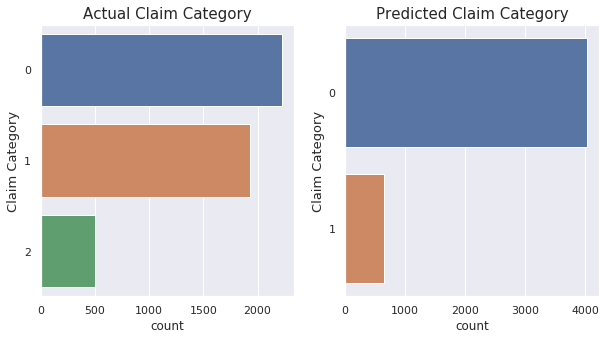

In [0]:
# Comparison between actual and predicted labels
fig, ax =plt.subplots(1,2)
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 10,15

sns.countplot(y=resultDF['Label'], ax=ax[0])
sns.countplot(y=resultDF['Prediction'], ax=ax[1])

ax[0].set_title('Actual Claim Category', fontsize = 15)
ax[0].set_ylabel('Claim Category', fontsize = 13)

ax[1].set_title('Predicted Claim Category', fontsize = 15)
ax[1].set_ylabel('Claim Category', fontsize = 13)

fig.show()